In [1]:
import os
import boto3
import logging
from datetime import datetime

import sagemaker
import pandas as pd
import numpy as np
from sagemaker.transformer import Transformer


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


SETTINGS

In [7]:
ep_config_name = "sample-configuration-new" # Endpoint configuration name
ep_name = "sample-enpoint-new" # Endpoint name
ep_config_variant = "version-1"
model_name ="my-logistic-model-from-training-job-new"

# The S3 bucket name and the file key
input_bucket_name = 'sagemaker-bucket-ds'
input_file_key = 'training-jobs/data/inference_input/iris_inference.csv'

local_directory = "10_online_prediction" # Local path where the file will be saved

BASIC OBJECTS

In [3]:
sagemaker_client = boto3.client("sagemaker")
sagemaker_runtime = boto3.client("runtime.sagemaker")
s3 = boto3.client('s3')

CREATE ENDPOINT CONFIG

In [4]:
# The response is not an endpoint config object itself. It is used only to validate whether operation was successful
response = sagemaker_client.create_endpoint_config(
    EndpointConfigName=ep_config_name,
    ProductionVariants=[
        {
            "VariantName": ep_config_variant,
            "ModelName": model_name,
            "InitialInstanceCount": 1,
            "InstanceType": "ml.m5.large",
        },
    ],
)

print(response)

{'EndpointConfigArn': 'arn:aws:sagemaker:eu-west-1:211125740051:endpoint-config/sample-configuration-new', 'ResponseMetadata': {'RequestId': '352a61eb-2179-4797-85a9-d297d39bb2d5', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '352a61eb-2179-4797-85a9-d297d39bb2d5', 'content-type': 'application/x-amz-json-1.1', 'content-length': '105', 'date': 'Mon, 01 Jul 2024 15:23:36 GMT'}, 'RetryAttempts': 0}}


ENDPOINT CONFIGURATION IS READY
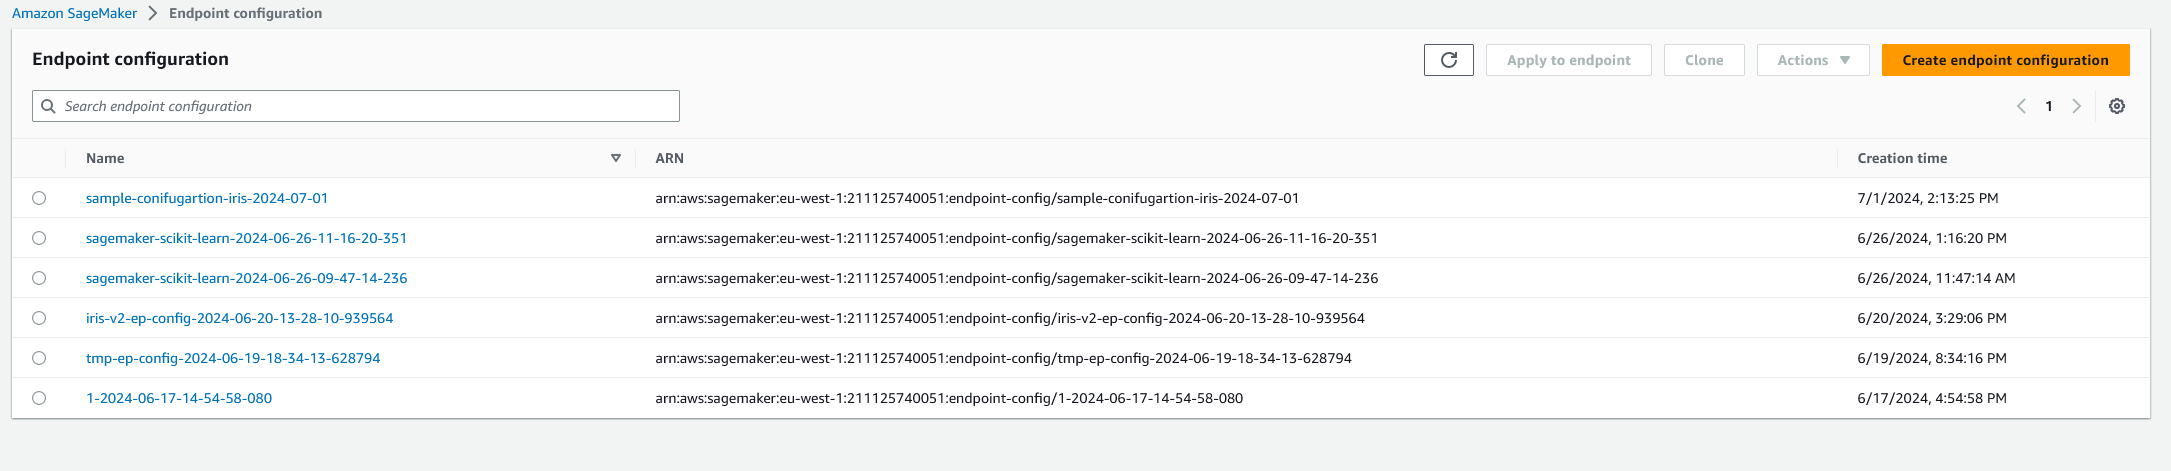

CREATE ENDPOINT

Remember that AWS charge costs since endpoint is created till it is deleted!

The costs are incurred even if you dont calculate the predictions!

In [5]:
# The response is not an endpoint object itself. It is used only to validate whether operation was successful
response = sagemaker_client.create_endpoint(
    EndpointName=ep_name, 
    EndpointConfigName=ep_config_name,
)
print(response)

{'EndpointArn': 'arn:aws:sagemaker:eu-west-1:211125740051:endpoint/sample-enpoint-new', 'ResponseMetadata': {'RequestId': 'dfec9aff-afde-4ab1-b187-a0cb94ebae4b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'dfec9aff-afde-4ab1-b187-a0cb94ebae4b', 'content-type': 'application/x-amz-json-1.1', 'content-length': '86', 'date': 'Mon, 01 Jul 2024 15:23:40 GMT'}, 'RetryAttempts': 0}}


ENDPOINT IS BEING CREATED
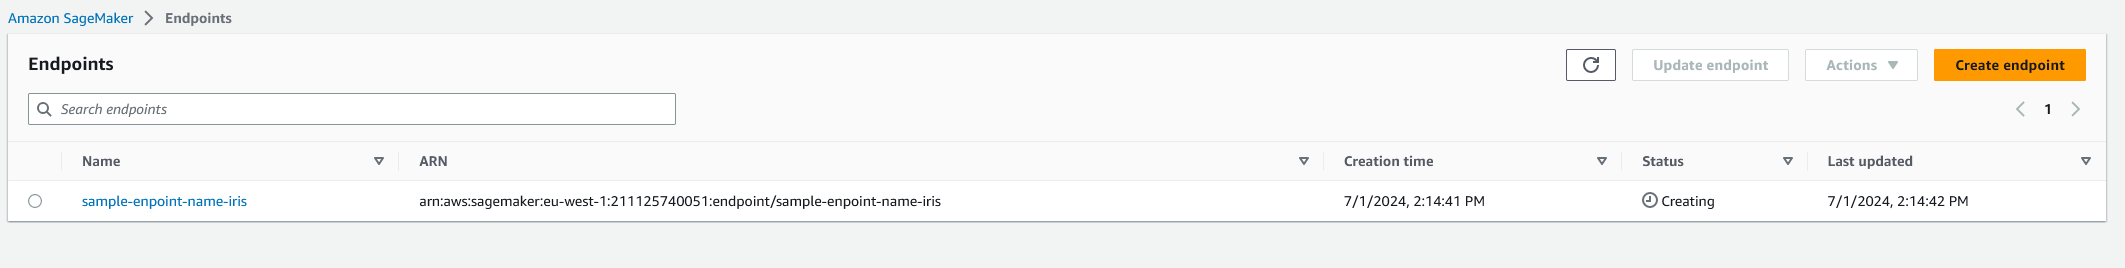

In [6]:
# It will wait till the endpoint is created
waiter = sagemaker_client.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=ep_name, WaiterConfig={"Delay": 5, "MaxAttempts": 123})
print("Endpoint created")

Endpoint created


DOWNLOAD INPUT DATA

In [8]:
os.makedirs(local_directory, exist_ok=True) # Create folder for training code

# Local path where the file will be saved
local_file_path = os.path.join(local_directory, 'iris_inference.csv')

# Download the file from S3
s3.download_file(input_bucket_name, input_file_key, local_file_path)

CALCULATE PREDICTIONS

In [9]:
csv_buffer = open(local_file_path)
payload_csv_text = csv_buffer.read()

response = sagemaker_runtime.invoke_endpoint(
    EndpointName=ep_name, ContentType="text/csv", Body=payload_csv_text
)
print(response["Body"].read().decode())

[[0.024824997725132802, 0.9751750022748672], [0.9698947778160268, 0.03010522218397316], [0.006183774539202269, 0.9938162254607977], [0.981101313430132, 0.01889868656986807], [0.9718610428858032, 0.028138957114196728], [0.9857807590418143, 0.014219240958185752], [0.9929929753911424, 0.00700702460885759], [0.9745326692855031, 0.02546733071449695], [0.9838090032301294, 0.0161909967698706], [0.008579796164181253, 0.9914202038358187], [0.02252742142360309, 0.9774725785763969], [0.9703902170425291, 0.02960978295747082], [0.030662615118854486, 0.9693373848811455], [0.15979578716199405, 0.840204212838006], [0.9618051556406356, 0.03819484435936438], [0.008902446392800134, 0.9910975536071999], [0.011458438998945275, 0.9885415610010547], [0.9724143689831092, 0.02758563101689081], [0.9728617891754765, 0.027138210824523494], [0.9486967512556147, 0.05130324874438528], [0.0019344792947912914, 0.9980655207052087], [0.005882028015631646, 0.9941179719843684], [0.9829396426470469, 0.017060357352953033], 

DELETE THE ENDPOINT

In [10]:
response = sagemaker_client.delete_endpoint(EndpointName = ep_name)  
print("Deleted sagemaker endpoint")   

Deleted sagemaker endpoint
